#DEAP Tutorial
## talk by Robert Coop 8/17/2015
* http://deap.readthedocs.org/en/master/

###General concepts
DEAP uses a slightly different approach than you're used to:

* Centralized classes are used to keep track of goals, types of individuals, and other parameters
 * E.g. the creator and toolbox classes


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import random
import numpy as np

from deap import base
from deap import creator
from deap import gp
from deap import tools

### populations and individuals
* one of the more important considerations
* should lend itself to the algorithm and problem at hand
* most common
    - real valued
    - binary valued
    - tree-like structure
    
### crossovers
* requirement -- a function converting two or more parent solutions into one or more children solutions
* simple approaches:
    1. one-point or multi-point crossovers (i.e. one point per variable)
    2. tree-based crossover
   
## Adding Complexity
* covariance matrix adaptation evolution strategy (CMA-ES)
    - adapt covariance of mutations in order to efficiently reach optimal solutions

## More complexity!
* note your fitness function can be 'anything'
* why not use another machine learning technique as candidate solutions (i.e. neural net)
    - cooperatively coevolved synapses (CoSyNE)
    


## DEAP package (Distributed Evolutionary Algorithms in Python)

## Example 1 - The H1 function
<img src="files/h1.hires.png"/>

$$f_{h1}(\mathbf{x}) = \frac{\sin(x_1 - \frac{x_2}{8})^2 +             \sin(x_2 + \frac{x_1}{8})^2}{\sqrt{(x_1 - 8.6998)^2 +             (x_2 - 6.7665)^2} + 1}$$

The global optimum is: $\mathbf{x} = (8.6998, 6.7665)$, $f(\mathbf{x}) = 2$

*The Merits of a Parallel Genetic Algorithm in Solving Hard Optimization Problems, A. J. Knoek van Soest and L. J. R. Richard Casius, J. Biomech. Eng. 125, 141 (2003)*



In [9]:
# define the function
def fh1(x1,x2):
    value = (np.sin(x1 - x2/8)**2 + np.sin(x2+x1/8)**2)/(np.sqrt((x1-8.6998)**2 + (x2 - 6.7665)**2)+1.0)
    return value

In [11]:
fh1(8.699,6.7665)

1.9984006374705823

### Individual types, utilities and fitness functions

In [2]:
# creator is the main mechanism for defining objects

# Define the fitness criteria - maximize 1 objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Note that tuples are required in most places

# An individual is just a list of the two coordinates
creator.create("Individual", list, fitness=creator.FitnessMax)

IND_SIZE=2

In [4]:
# toolbox allows us to store functions to use and give them aliases

toolbox = base.Toolbox()
toolbox.register("attr_float", lambda: (random.random()-.5) * 40) # Initialization function, for [-20,20] range
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE) # Definition of the individual

ind1 = toolbox.individual()
ind2 = toolbox.individual()

print ind1
print ind2

[-17.460387902082925, -0.017349905786696596]
[19.171329359829947, 4.406935442092643]


In [5]:
# The function to optimize
from deap.benchmarks import h1

def fitness(individual):
    return h1(individual) # Note this returns a tuple

print ind1,'\t',fitness(ind1)
print ind2,'\t',fitness(ind2)

[-17.460387902082925, -0.017349905786696596] 	(0.05787241447217286,)
[19.171329359829947, 4.406935442092643] 	(0.02544770057519767,)


In [6]:
# Register the fitness function
toolbox.register("evaluate", h1)

### Genetic operators - mutation, crossover

Keep in mind - DEAP utility functions are very basic.  They do ***not*** make copies of individuals, so you have to remember to do that yourself if you don't want the source individual modified.

In [12]:
# Gaussian mutation
orig_ind1 = toolbox.clone(ind1)

ind2, = tools.mutGaussian(ind1, mu=0.0, sigma=5, indpb=1) 
# indpb is the probability that the mutation takes place; typical values are 5% to 20%

print 'Original individual - ',orig_ind1
print 'Note that the mutation modified the argument we passed - ',ind1
print 'Mutation also returned a reference to the argument - ',ind2 is ind1

Original individual -  [-17.460387902082925, -0.017349905786696596]
Note that the mutation modified the argument we passed -  [-24.333035616635218, 4.254974053440315]
Mutation also returned a reference to the argument -  True


#### Blended crossover - combining real vectors

$$f_\alpha(x,y) = \alpha x+(1-\alpha y)$$

In [13]:
child1, child2 = [toolbox.individual(),toolbox.individual()]
print 'Before crossover'
print 'Child 1 = ', child1
print 'Child 2 = ', child2

tools.cxBlend(child1, child2, 0.5)
print '\nAfter crossover'
print 'Child 1 = ', child1
print 'Child 2 = ', child2


Before crossover
Child 1 =  [-12.994236475578864, 12.157925517883532]
Child 2 =  [-4.63234392181338, 18.342307362801996]

After crossover
Child 1 =  [-13.173264571058693, 11.621049784015424]
Child 2 =  [-4.453315826333551, 18.8791830966701]


In [14]:
# Register these functions with the toolbox
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2) # We use a more reasonable mutation rate

### Populations and selection

In [15]:
from deap import benchmarks

def h1_arg0(sol):
    return benchmarks.h1(sol)[0]

X = np.arange(-25, 25, .1)
Y = np.arange(-25, 25, .1)
X, Y = np.meshgrid(X, Y)
Z = np.zeros(X.shape)

for i in xrange(X.shape[0]):
    for j in xrange(X.shape[1]):
        Z[i,j] = h1_arg0((X[i,j],Y[i,j]))

In [16]:
from matplotlib.colors import LogNorm, Normalize, PowerNorm

def plot_population(population):
    plt.figure(figsize=(20,20))
    plt.contourf(X, Y, Z, 50, cmap=plt.cm.RdYlBu_r, 
                 norm=Normalize())
    plt.colorbar()  # draw colorbar

    x = [ind[0] for ind in population]
    y = [ind[1] for ind in population]
    fitness = [ind.fitness.values[0] for ind in population]

    plt.scatter(x, y, marker='o', c=fitness, s=200)


In [40]:
POP_SIZE=20

def generate_population(POP_SIZE=20):
    return [toolbox.individual() for x in xrange(POP_SIZE)]

toolbox.register("population",generate_population, 20)

population = toolbox.population()

In [19]:
population

[[-19.778357261942197, -18.651286003760017],
 [1.7945681840862093, 10.95782202200931],
 [9.108254333341685, -1.053209703078637],
 [3.563685491357118, -12.874751468770969],
 [-0.617420708684091, -7.837518983045073],
 [9.453680283327763, -0.052954853252233924],
 [-7.278070939293189, -10.974827939796597],
 [-7.945332677615413, 4.786832204589175],
 [8.225514926483847, -13.410121326025223],
 [12.316370649986332, 12.928950336029747],
 [-1.6455844255989849, -12.202720082751712],
 [-0.3715746547657339, 18.939575081408158],
 [2.4012940082935286, -17.53426813751712],
 [-10.728193360599745, -12.575671720351242],
 [13.486526008849191, 11.664578534723663],
 [-1.6035976625240211, -19.721511890529907],
 [-6.644782848267163, 12.956041359934819],
 [9.0087252907625, 8.014536246454274],
 [-12.330157117137635, -6.03674841296157],
 [18.98438666049499, 18.982324851575317]]

In [18]:
fitnesses = toolbox.map(toolbox.evaluate, population)

In [24]:
ind1.fitness.valid

False

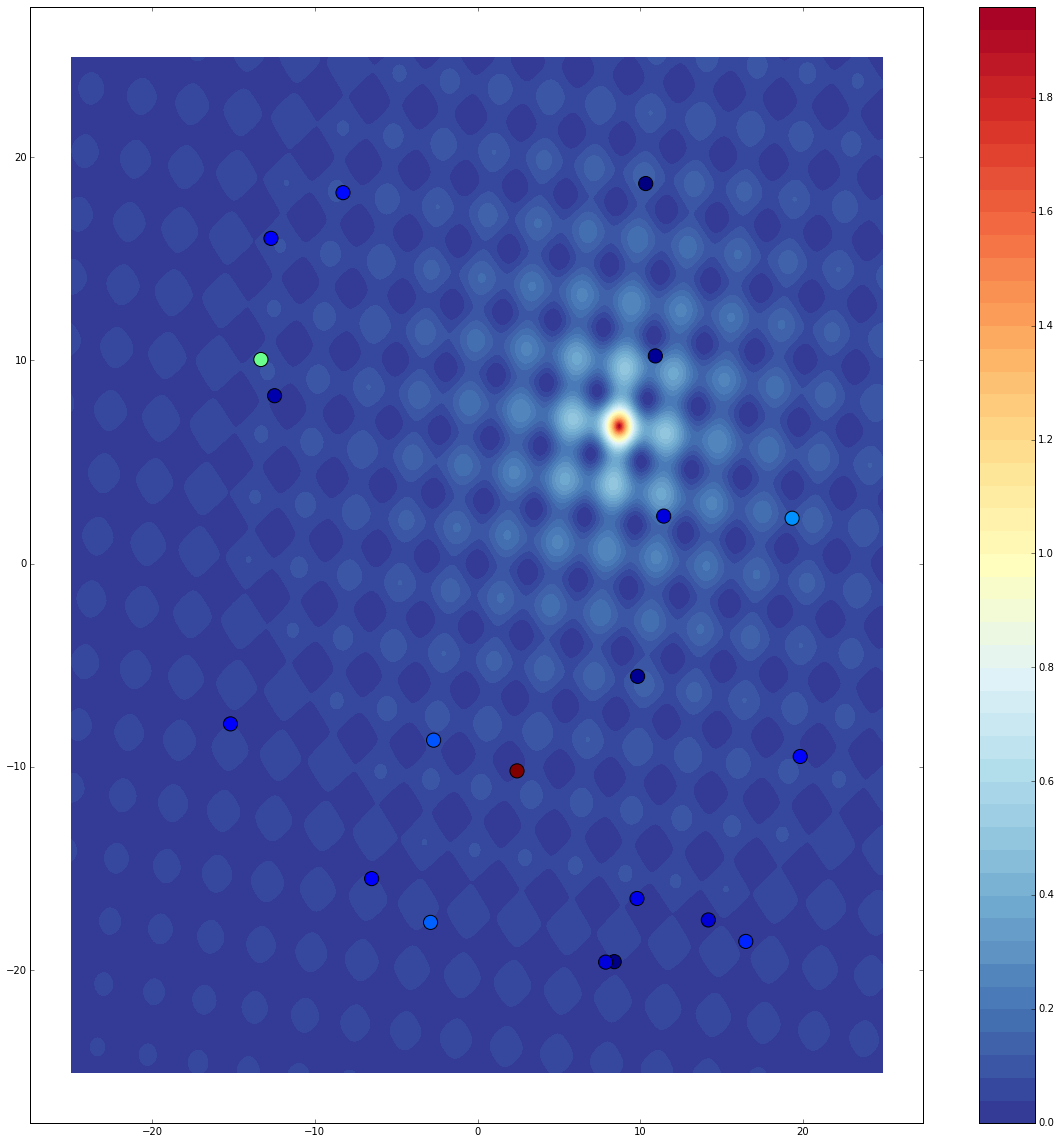

In [41]:
invalid_ind = [ind for ind in population if not ind.fitness.valid]
for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
plot_population(population)        

In [42]:
# Selection strategy - tournament
toolbox.register("select", tools.selTournament, tournsize=3)

In [43]:
def update_fitnesses(offspring):
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

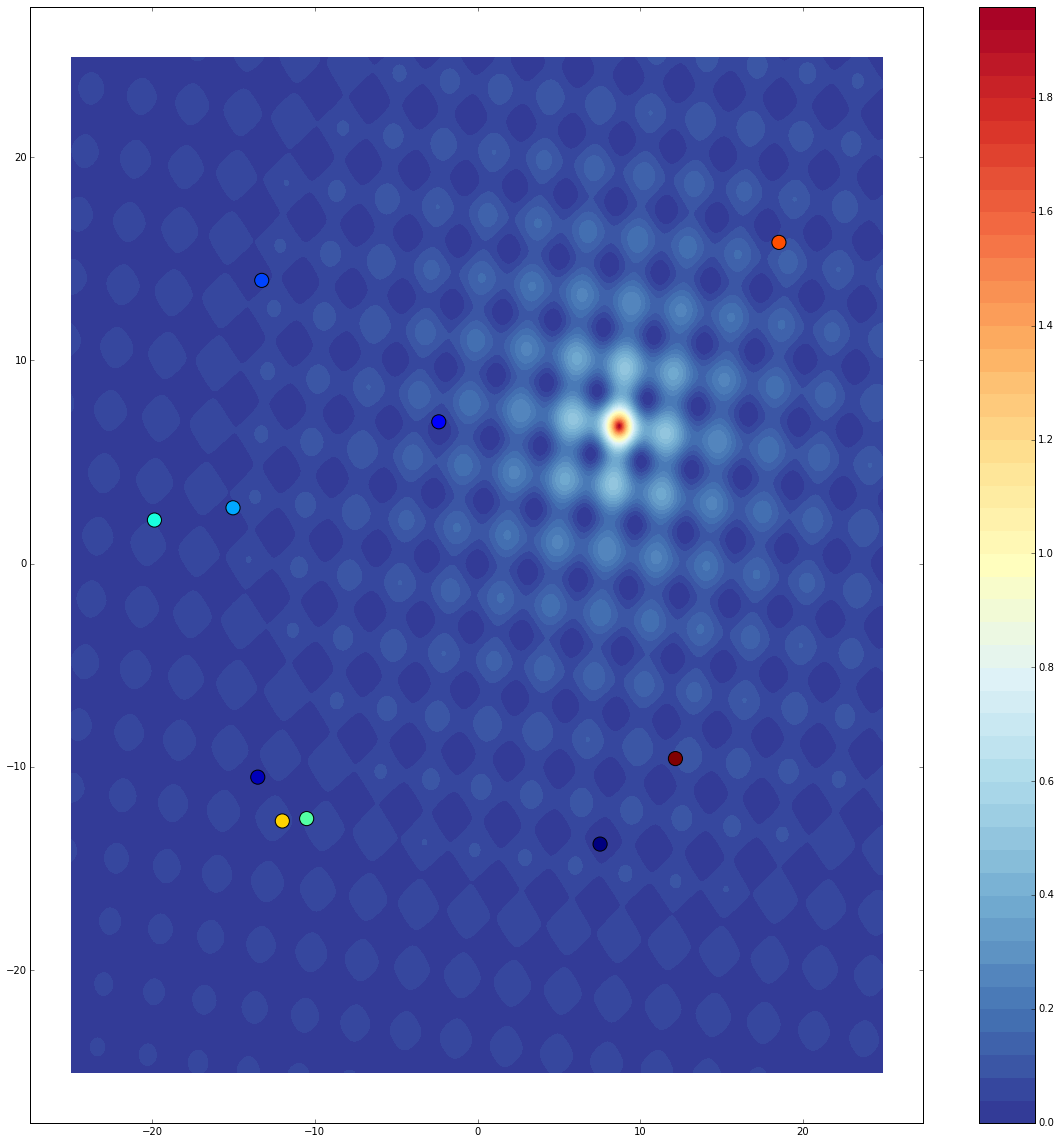

In [44]:
# Putting it all together
POP_SIZE = 10

population = [toolbox.individual() for x in xrange(POP_SIZE)]
update_fitnesses(population)
plt.figure(figsize=(5,5))
plot_population(population)

In [45]:
NGEN=20
CXPB=.5


def run_generation(population, plot=True):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))
    # Clone the selected individuals
    offspring = map(toolbox.clone, offspring)

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    update_fitnesses(offspring)

    if plot:
        plt.figure(figsize=(5,5))
        plot_population(population)
    # The population is entirely replaced by the offspring
    population[:] = offspring


/home/kesj/envs/cutting/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


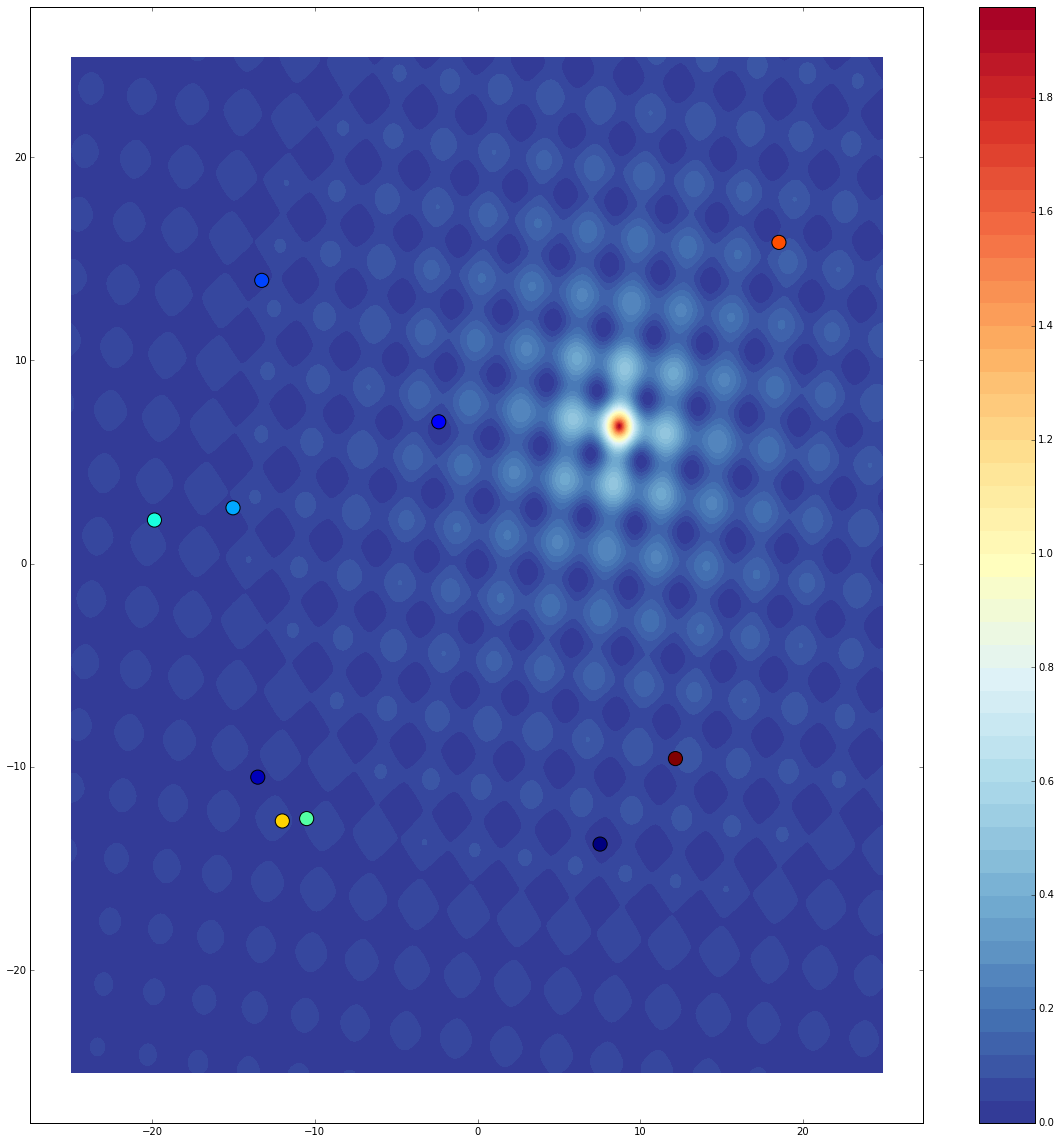

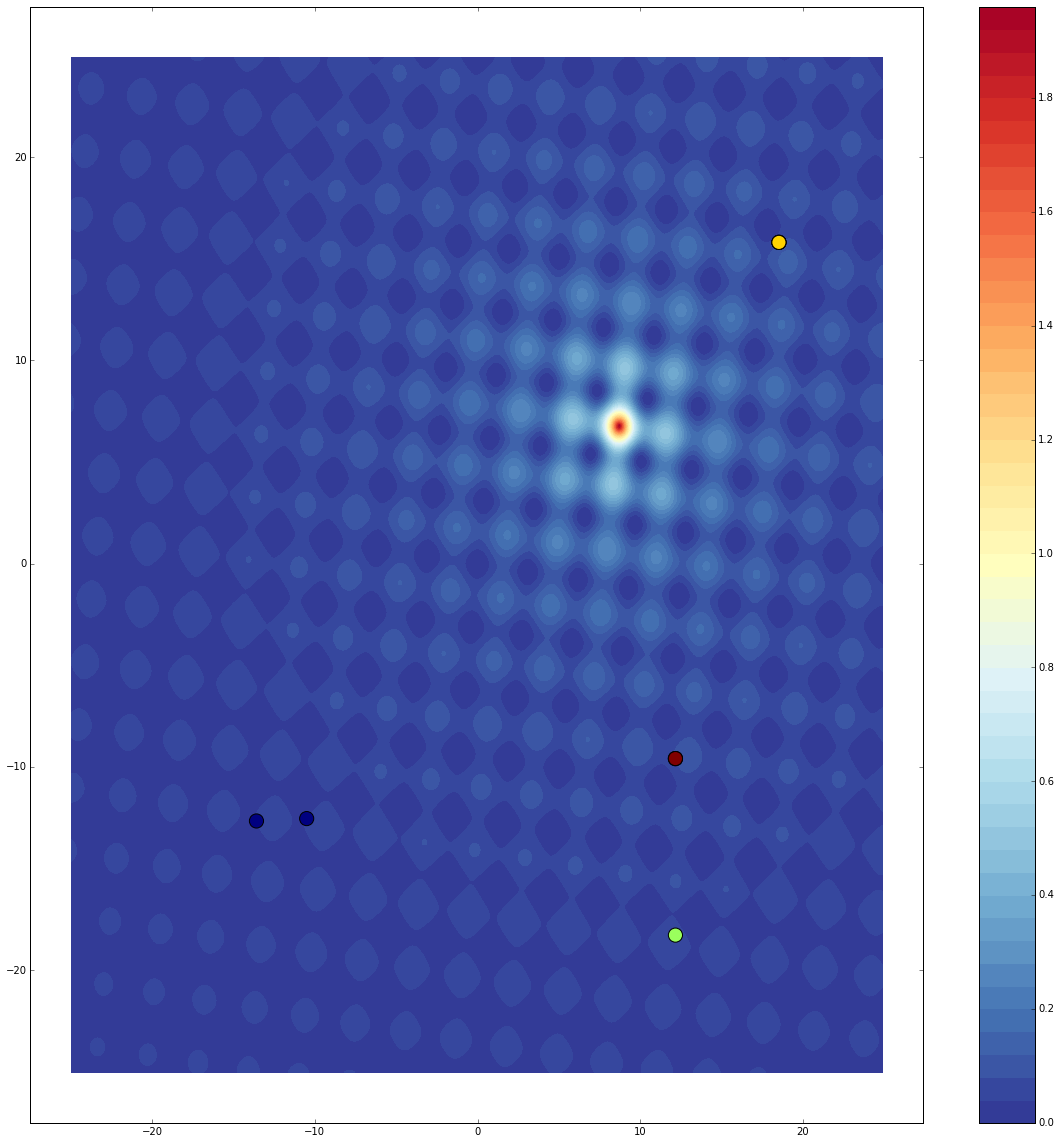

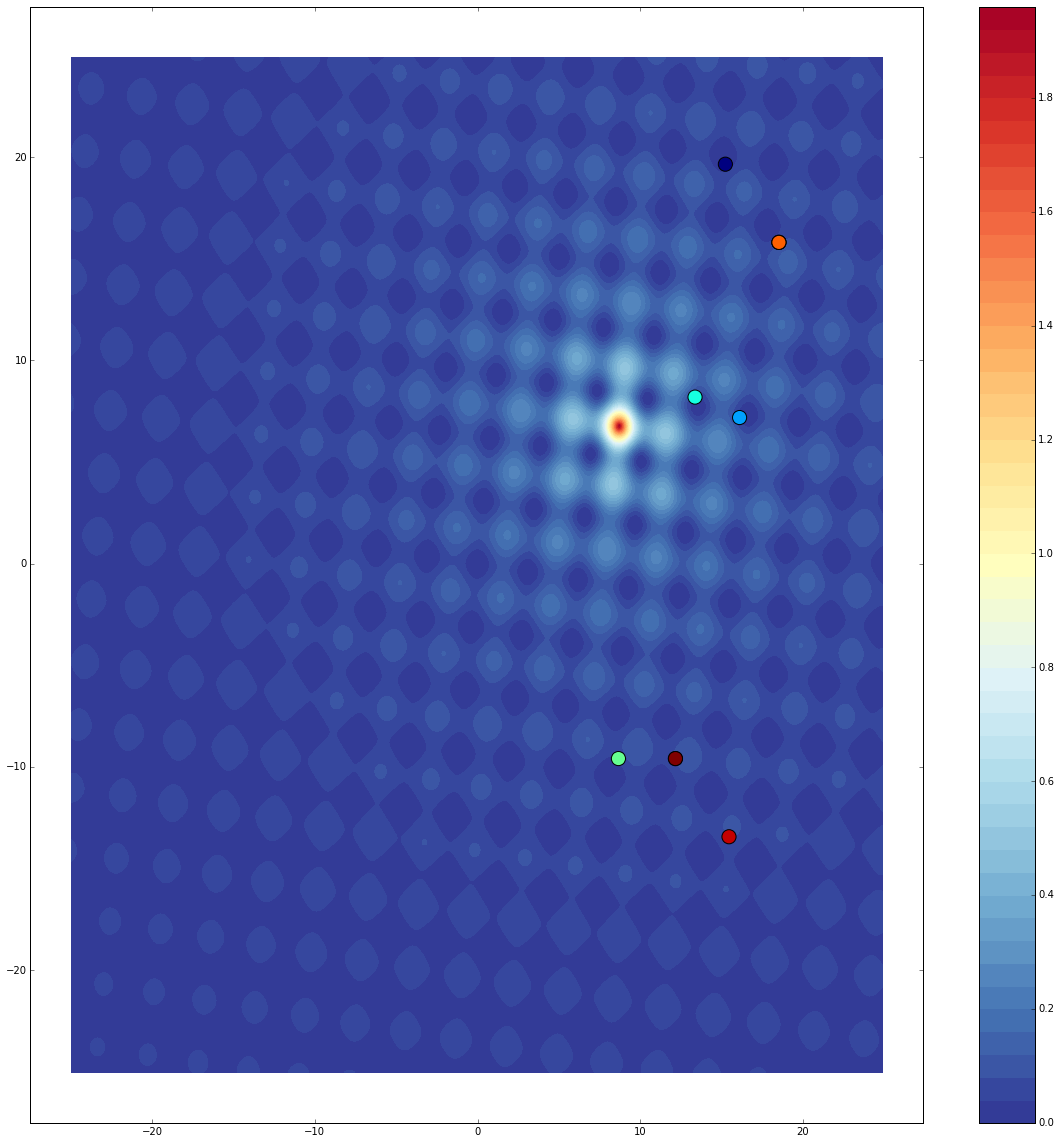

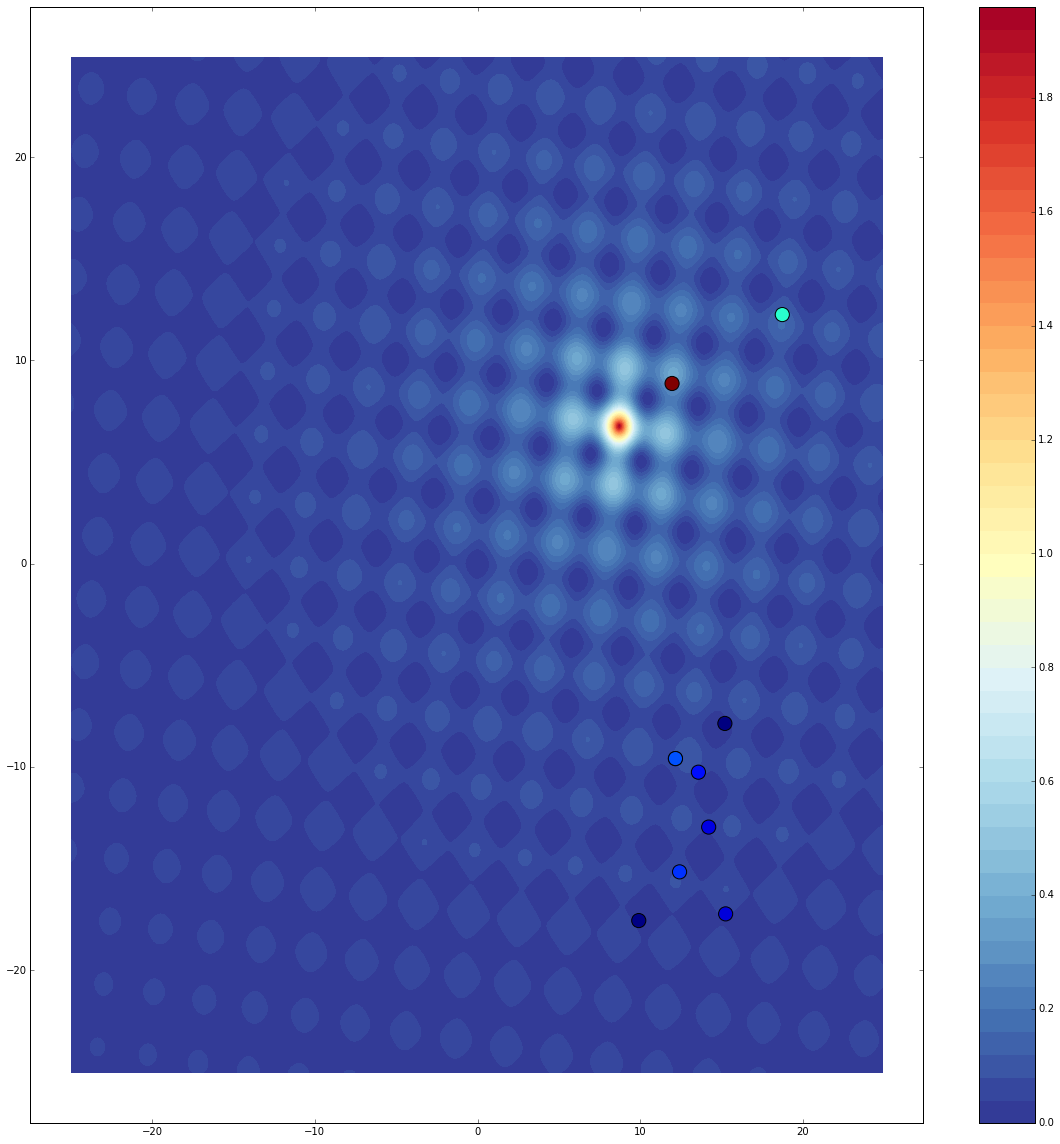

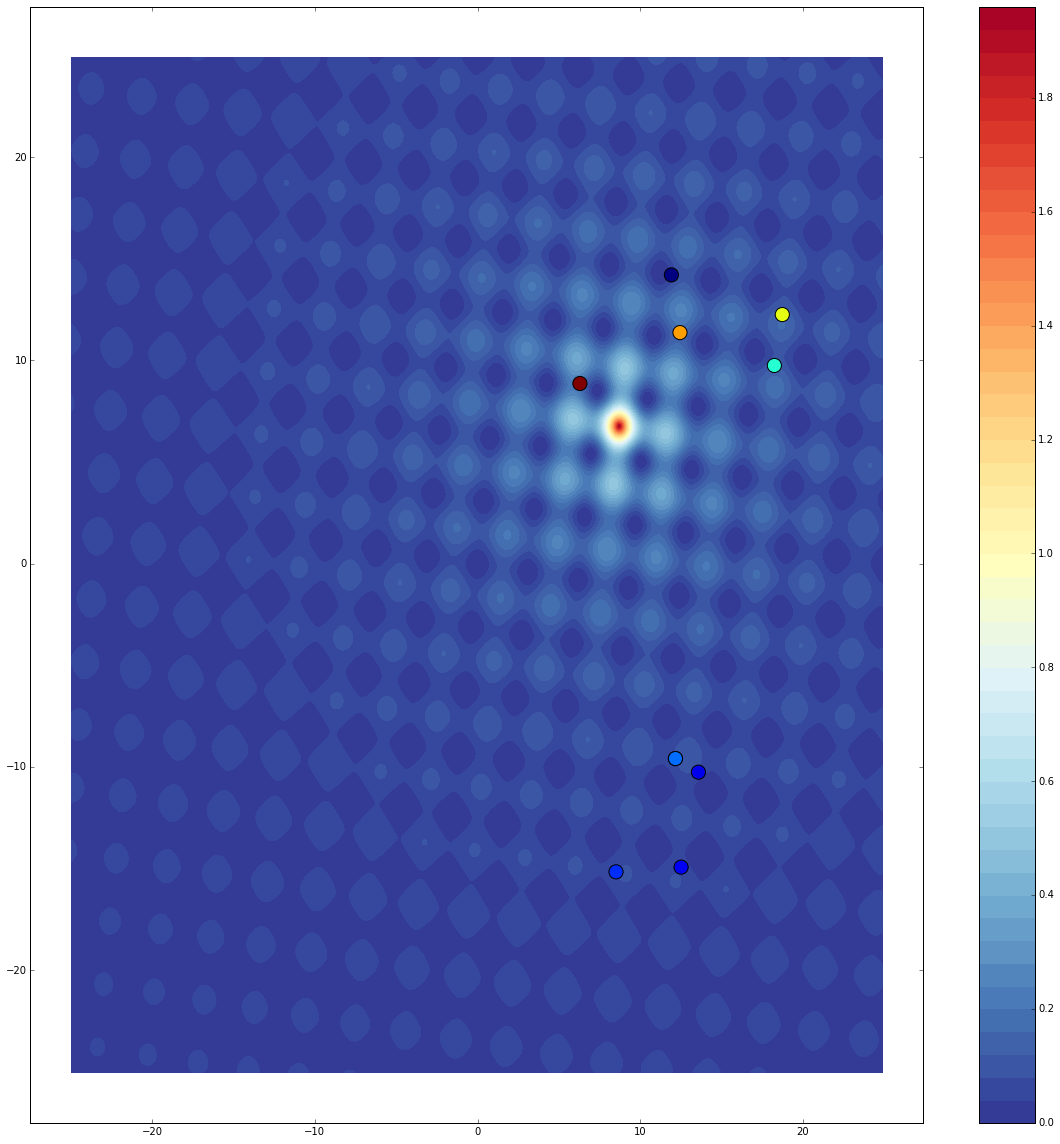

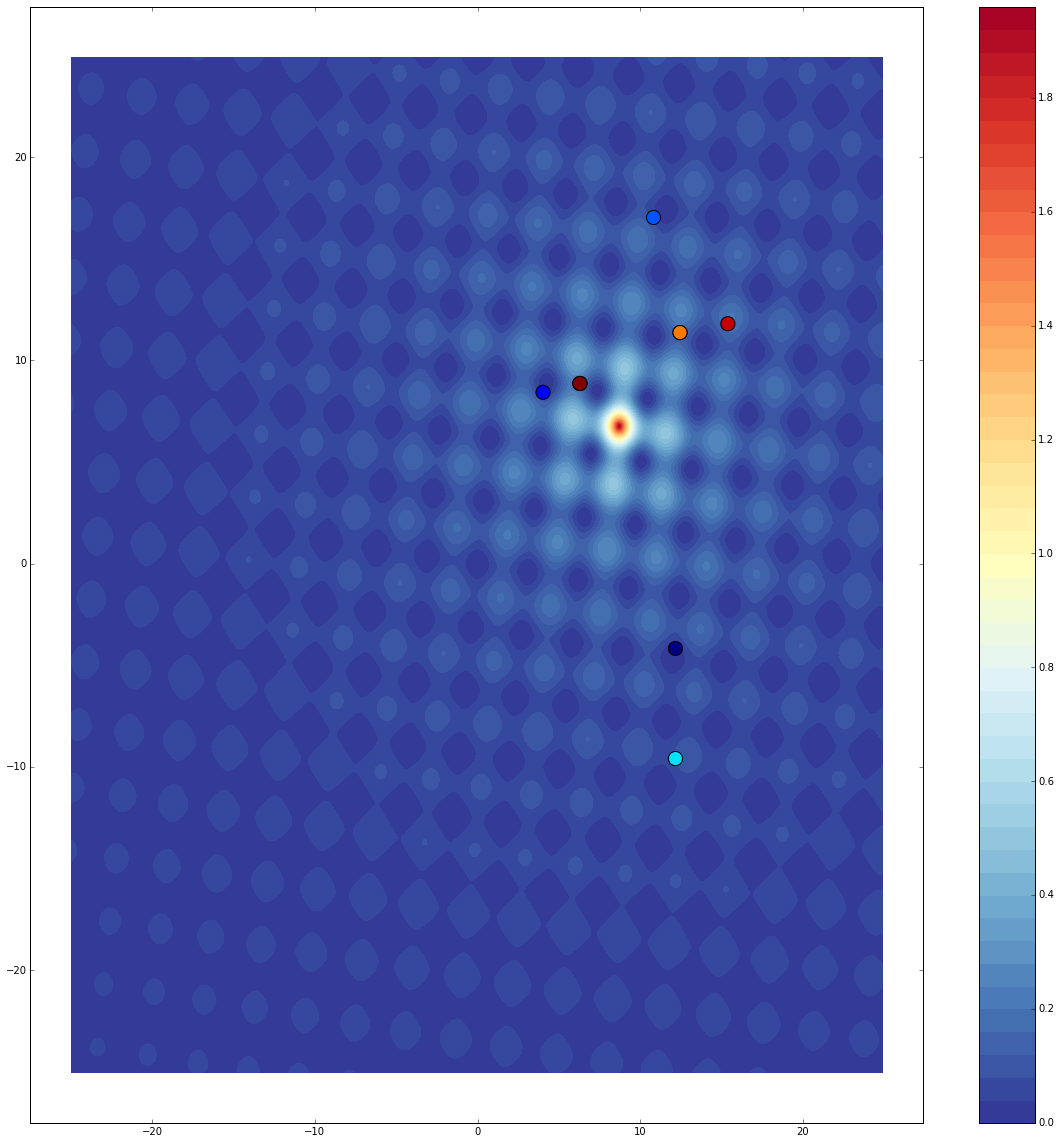

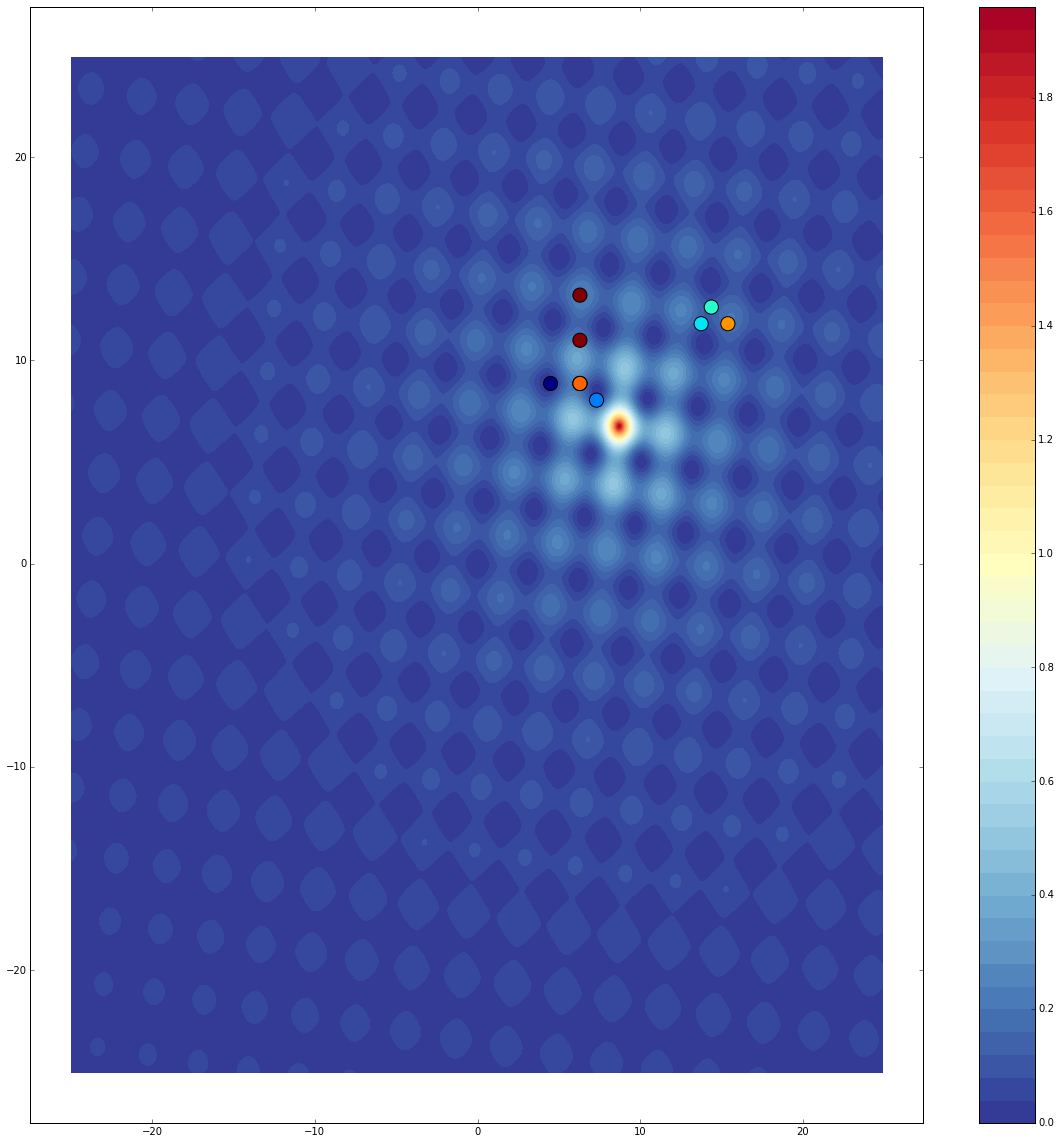

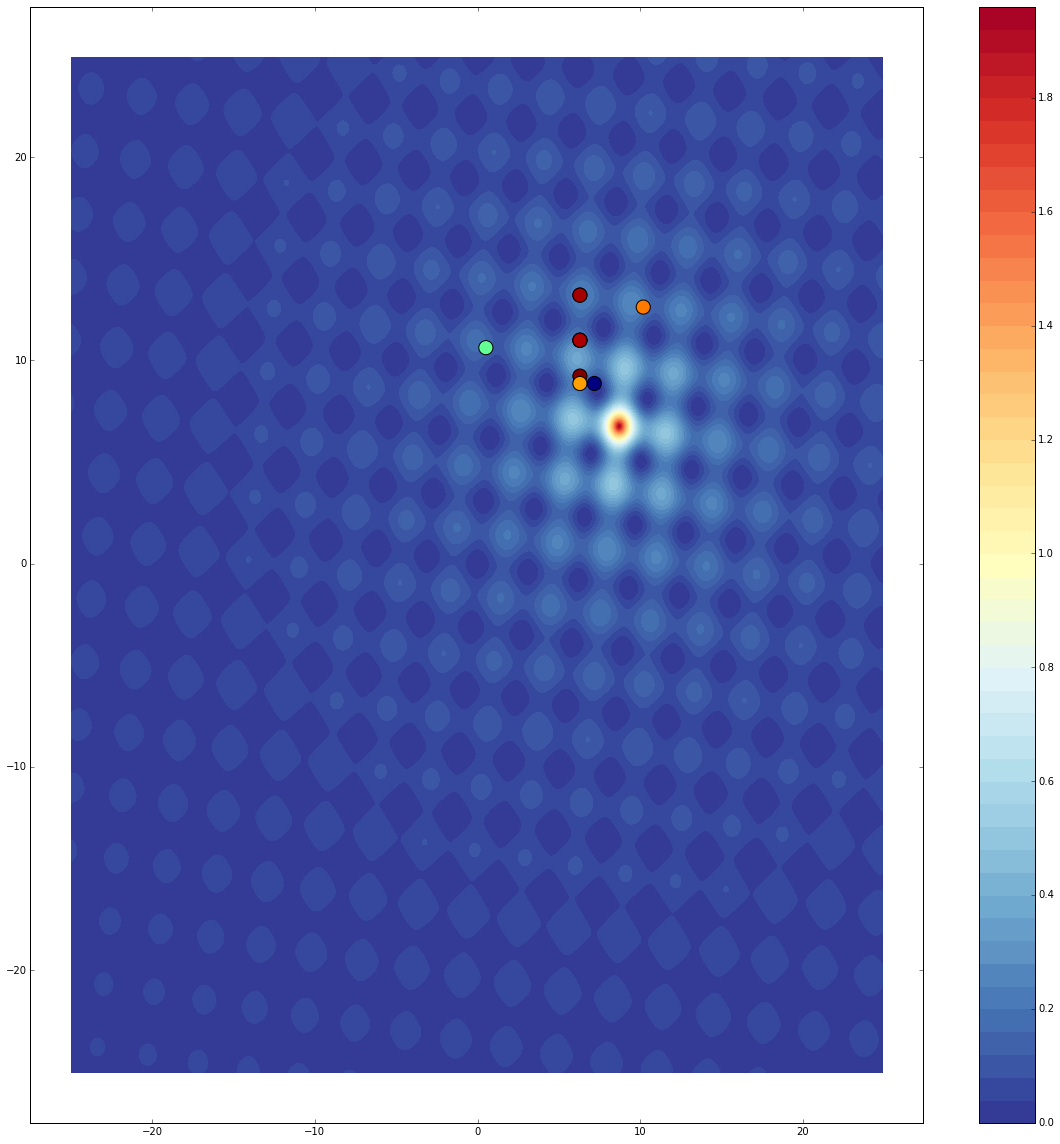

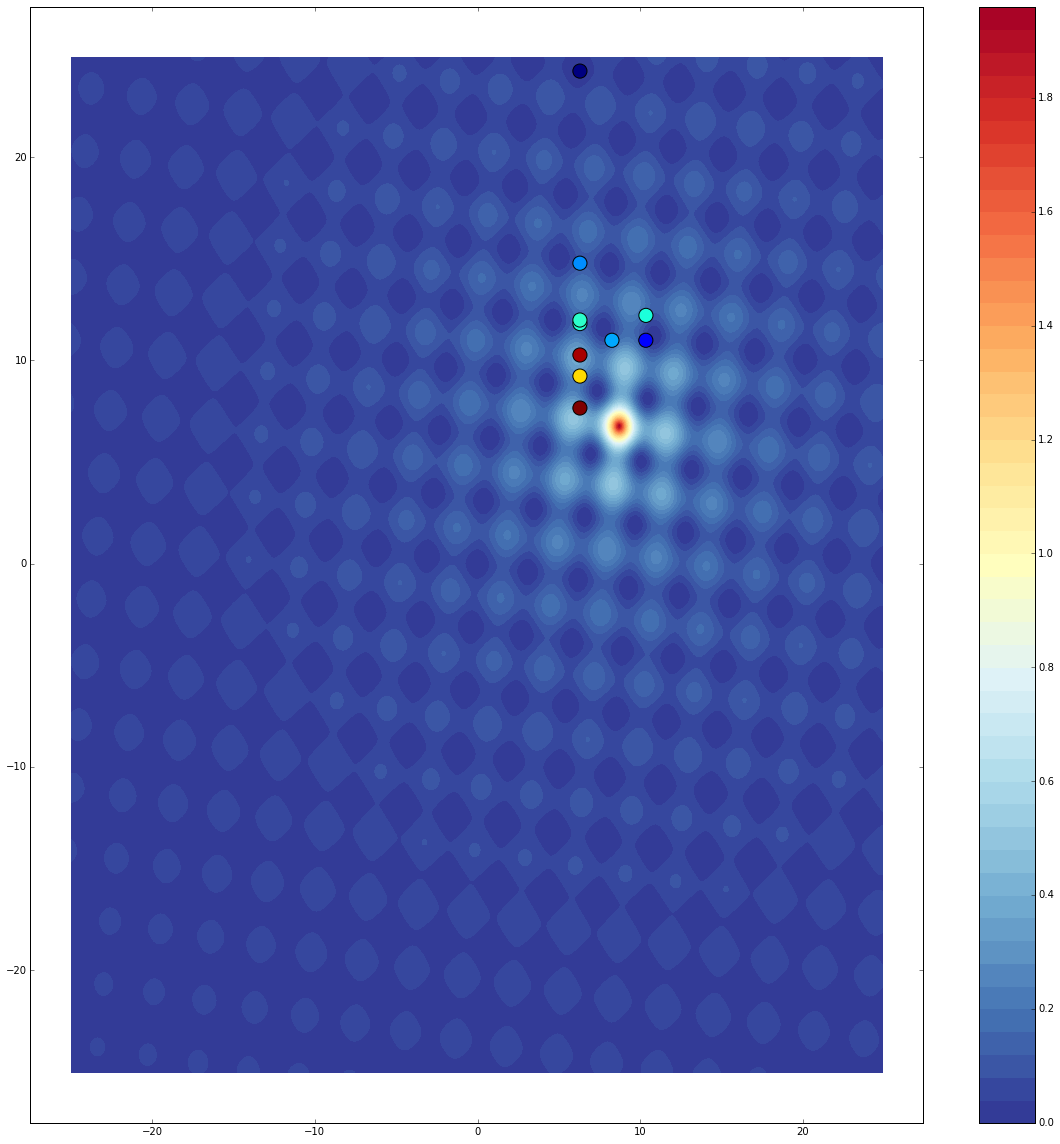

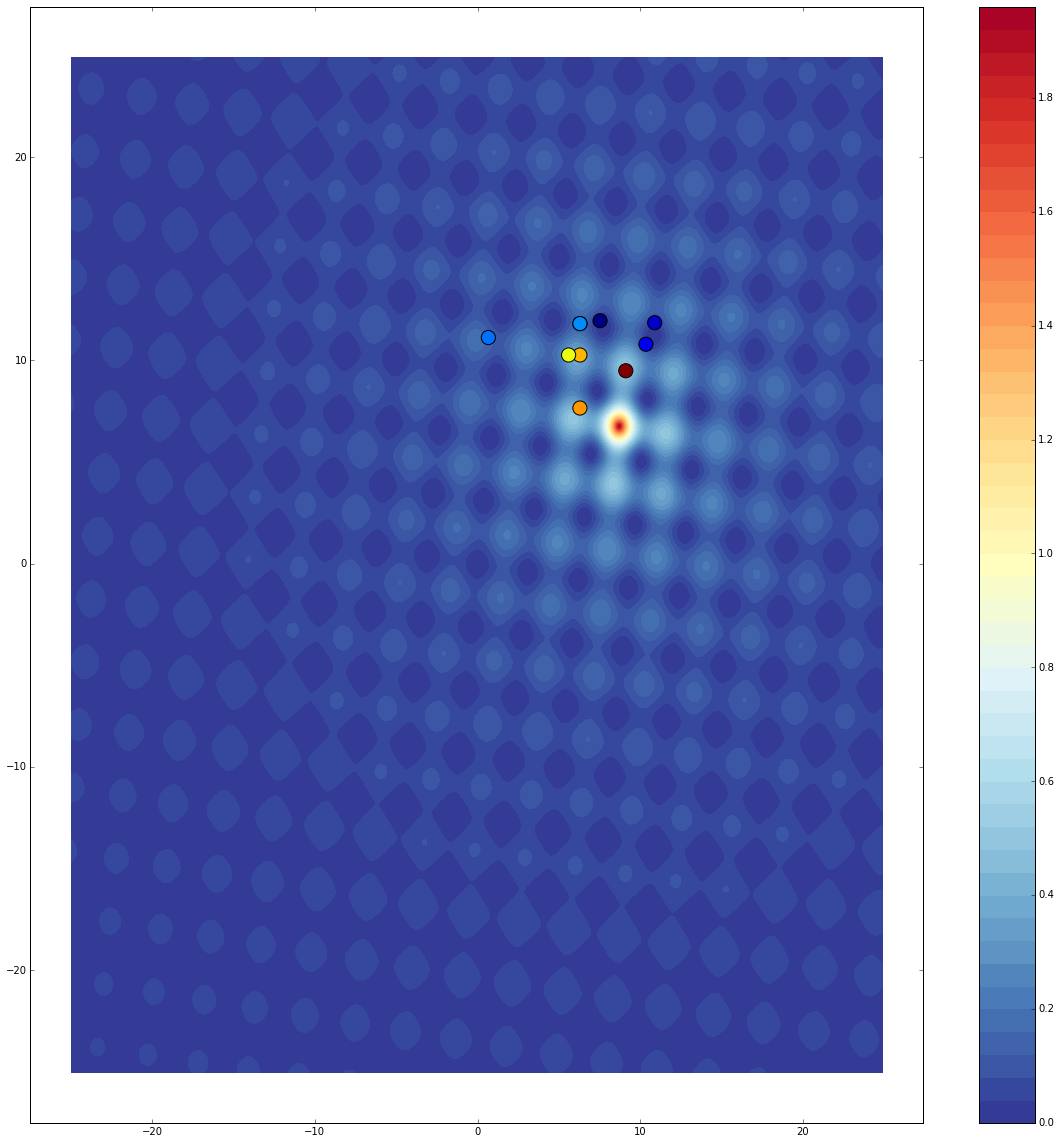

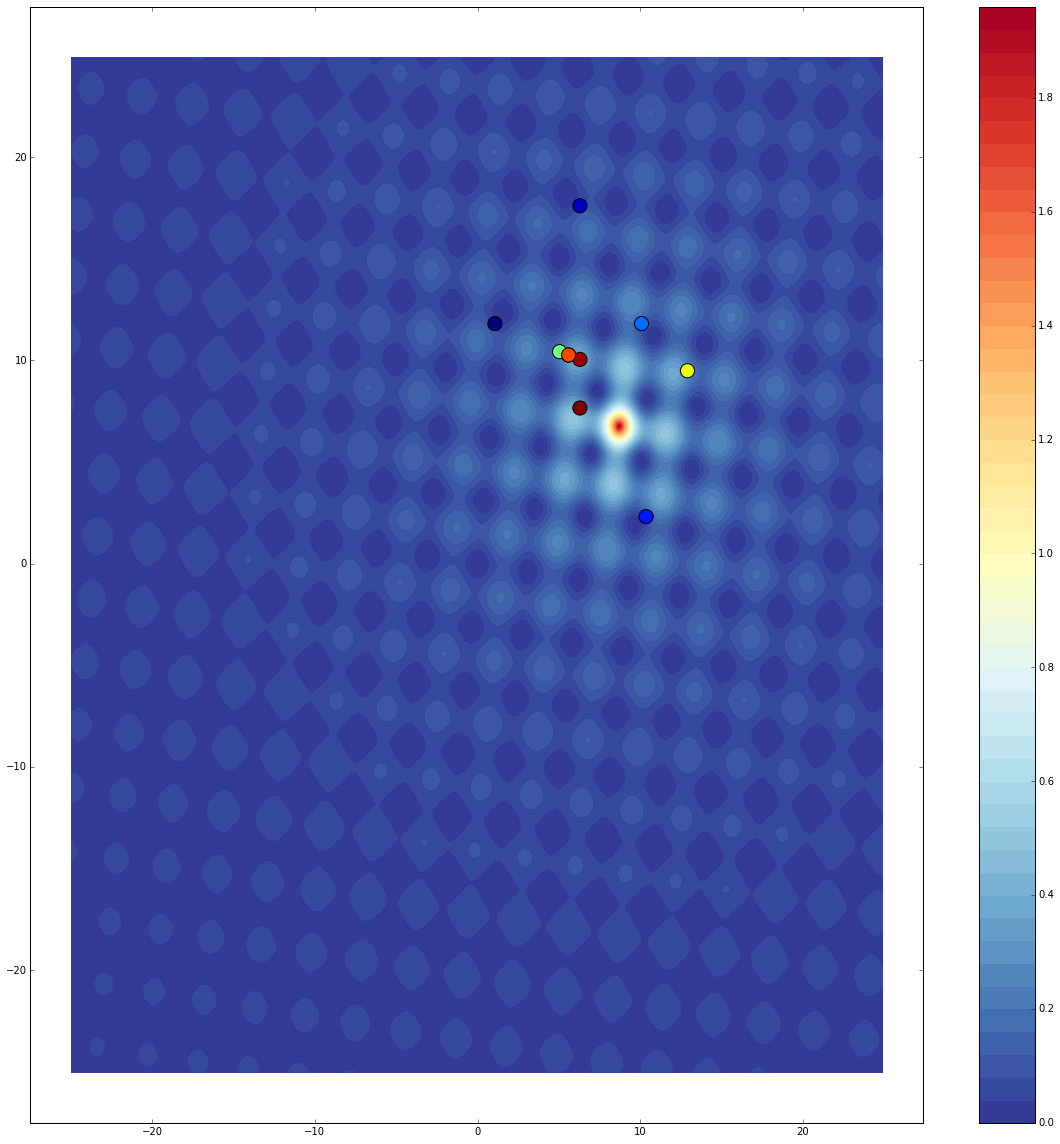

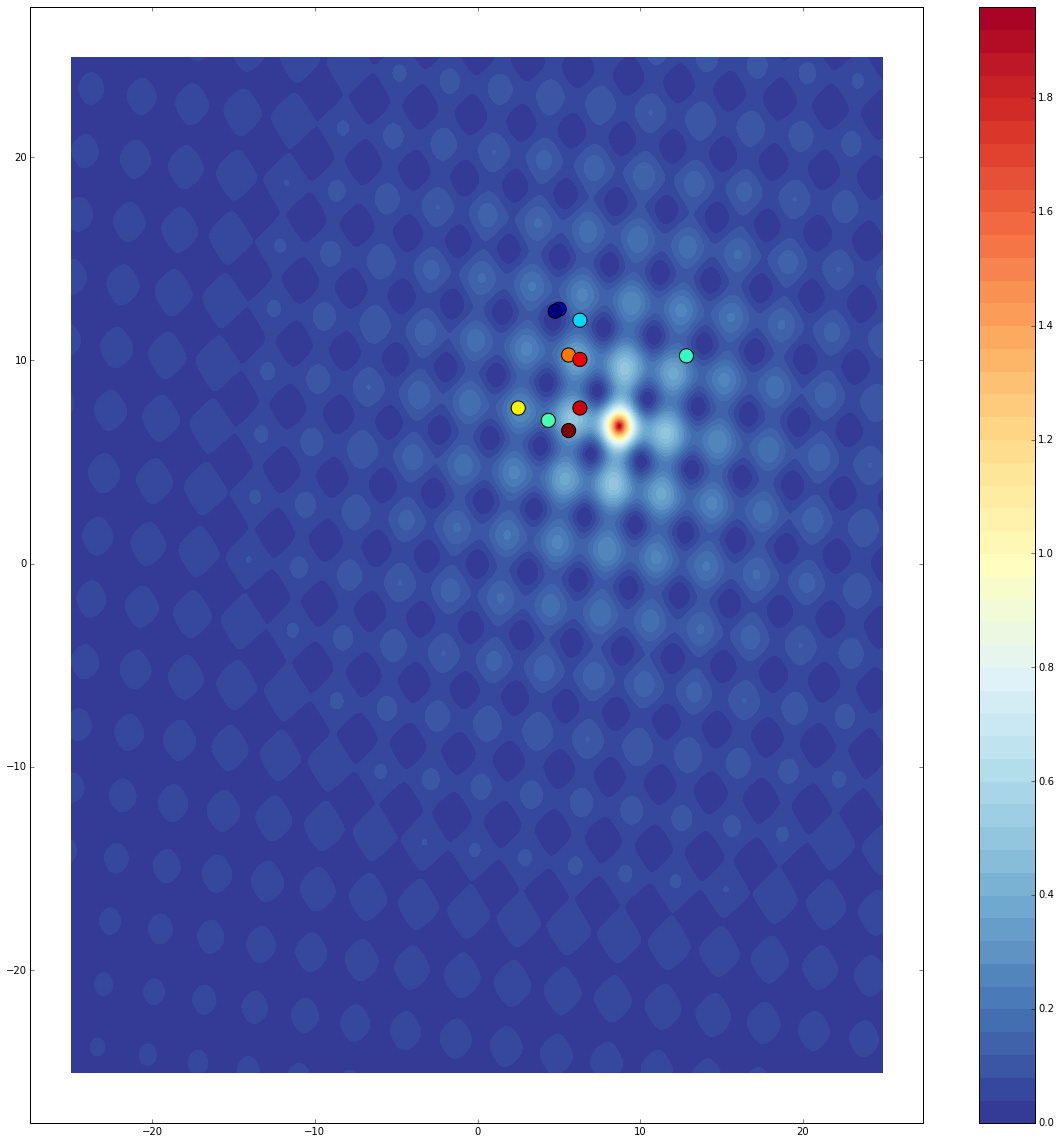

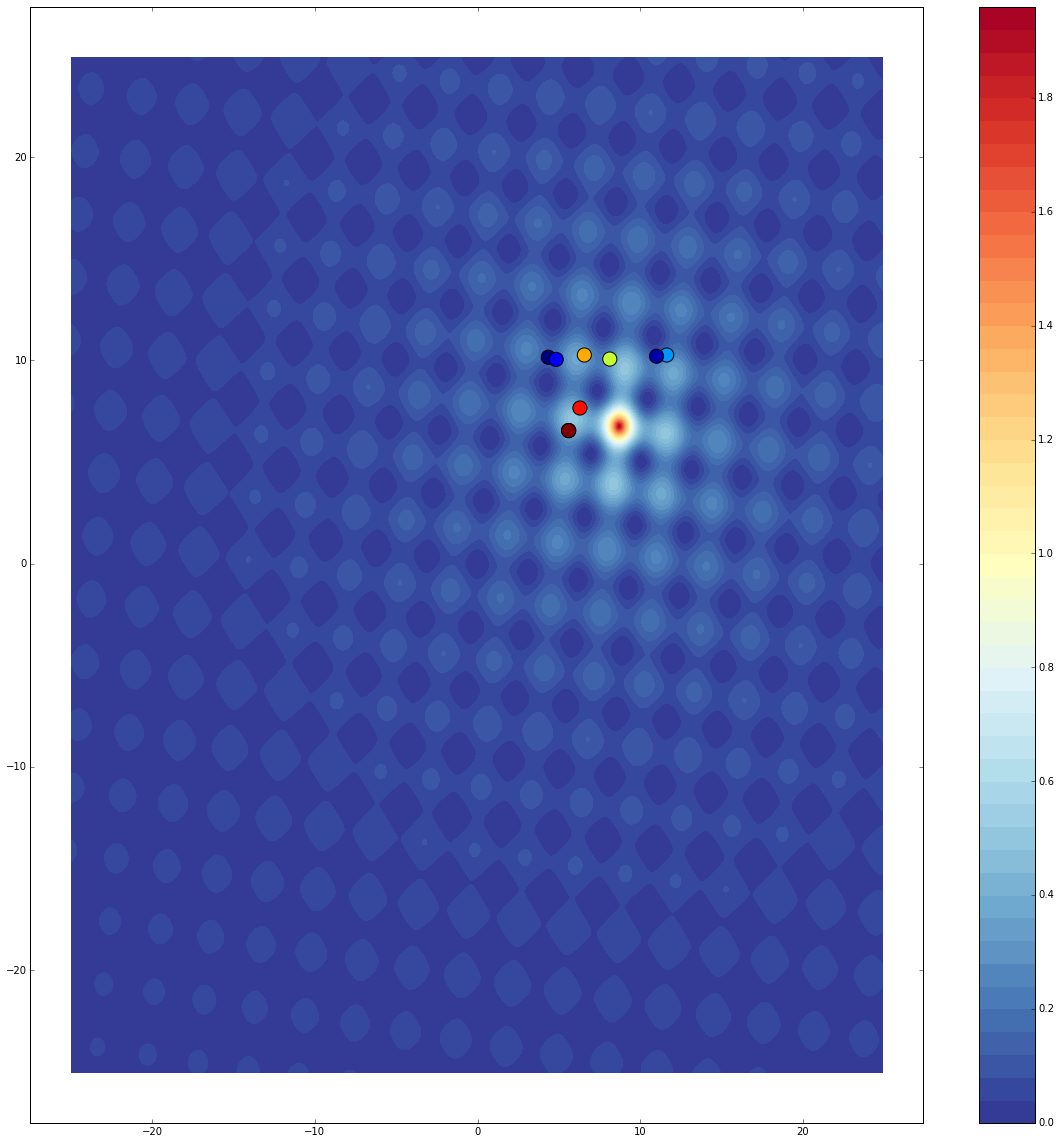

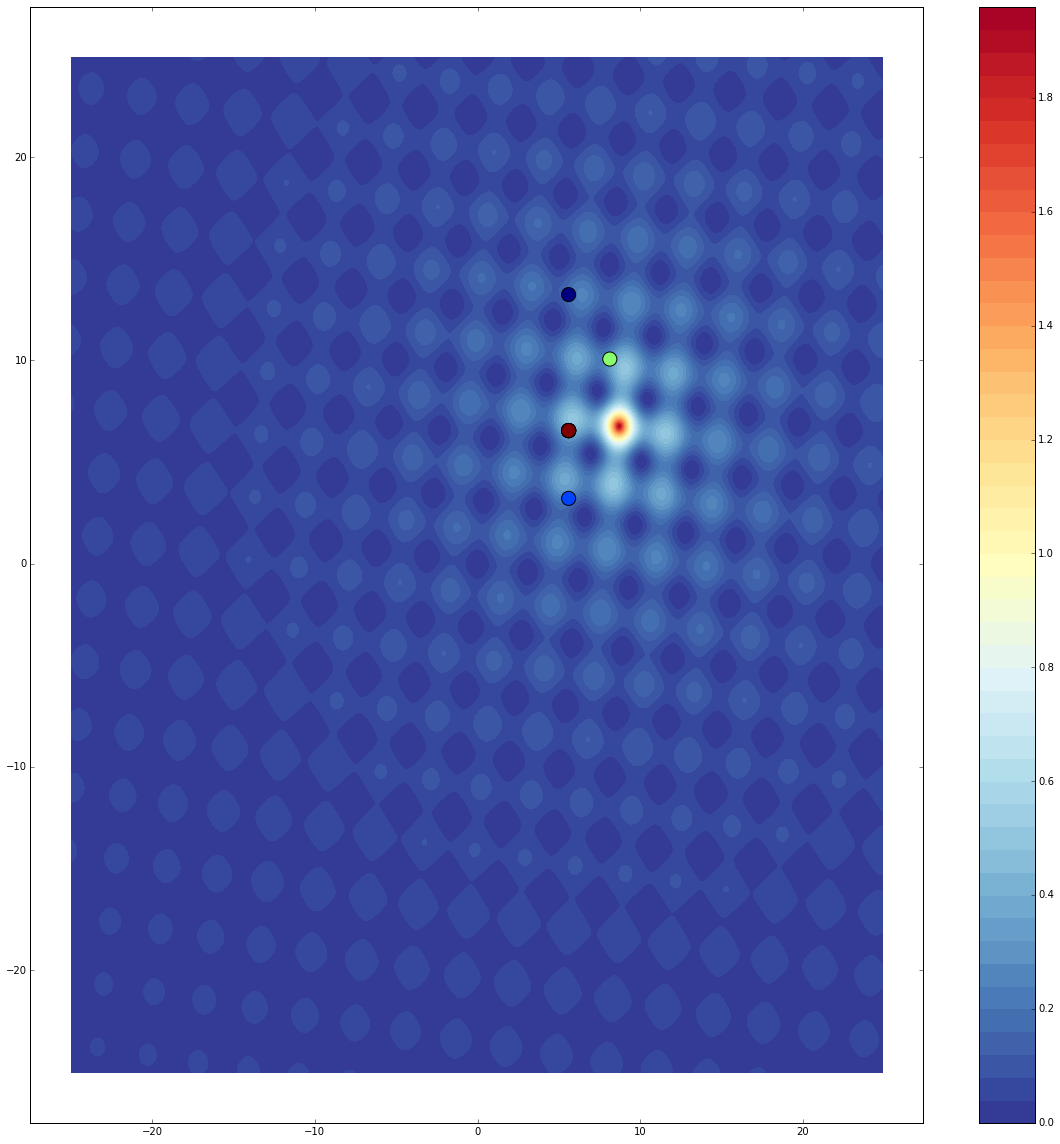

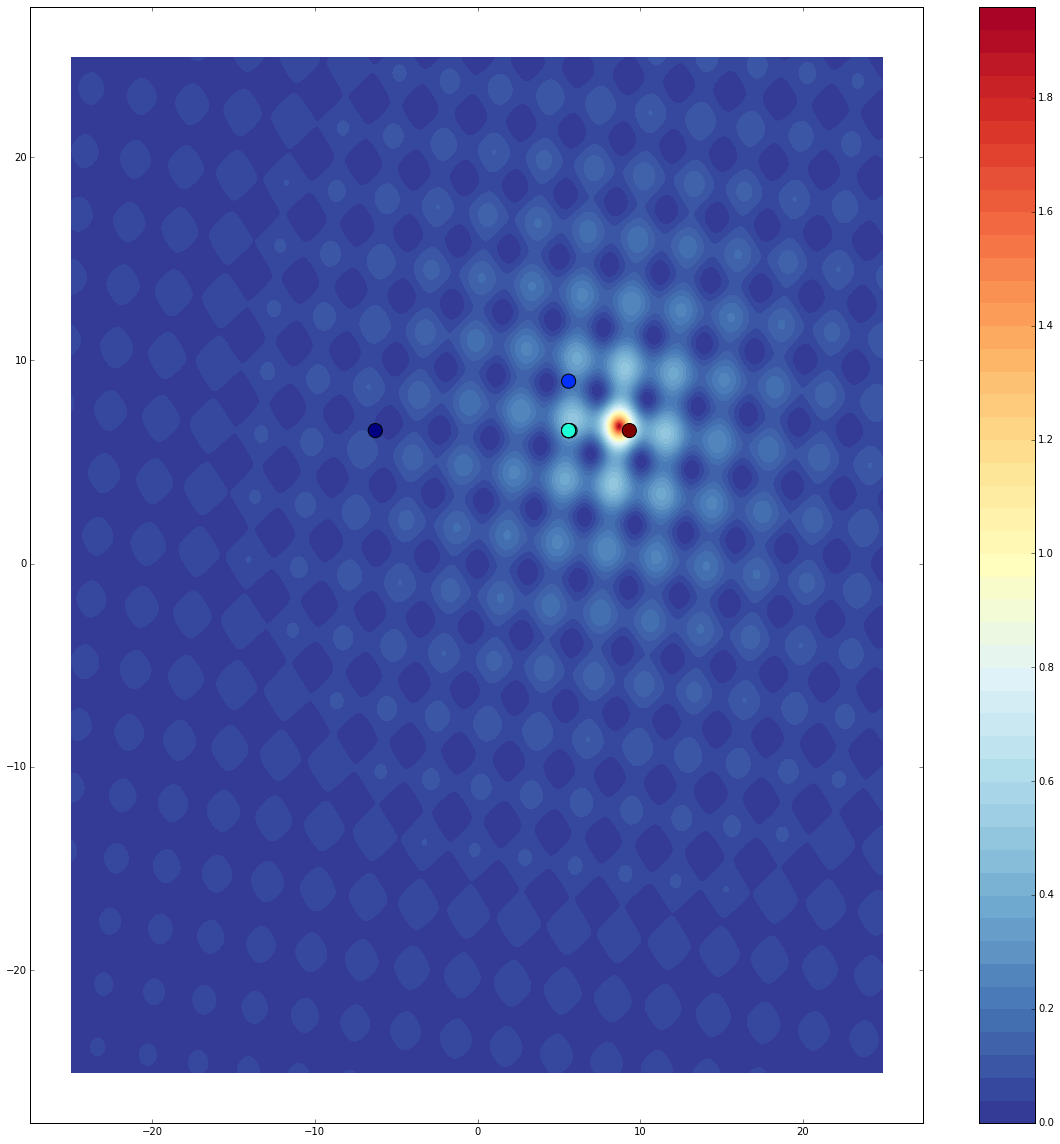

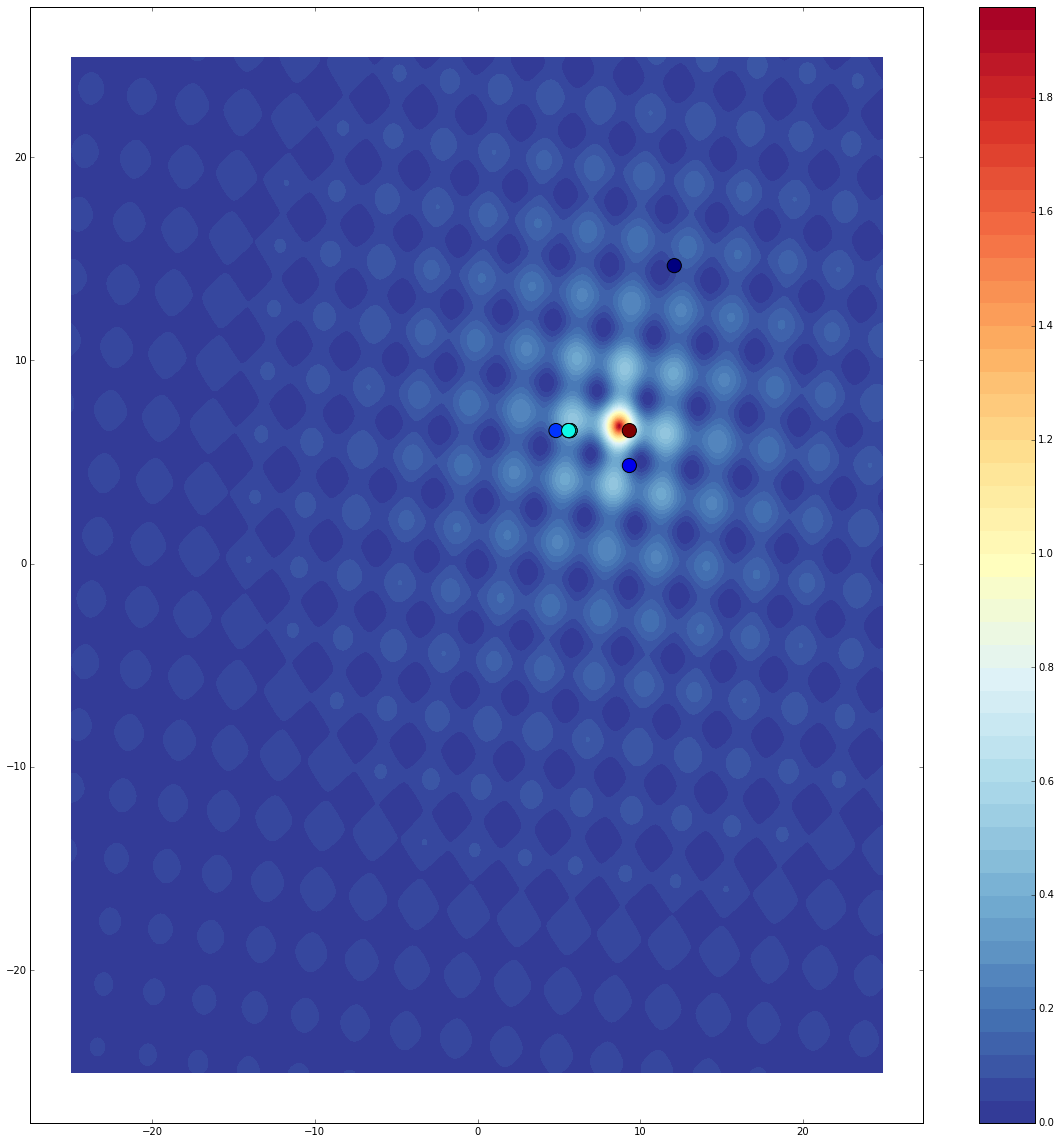

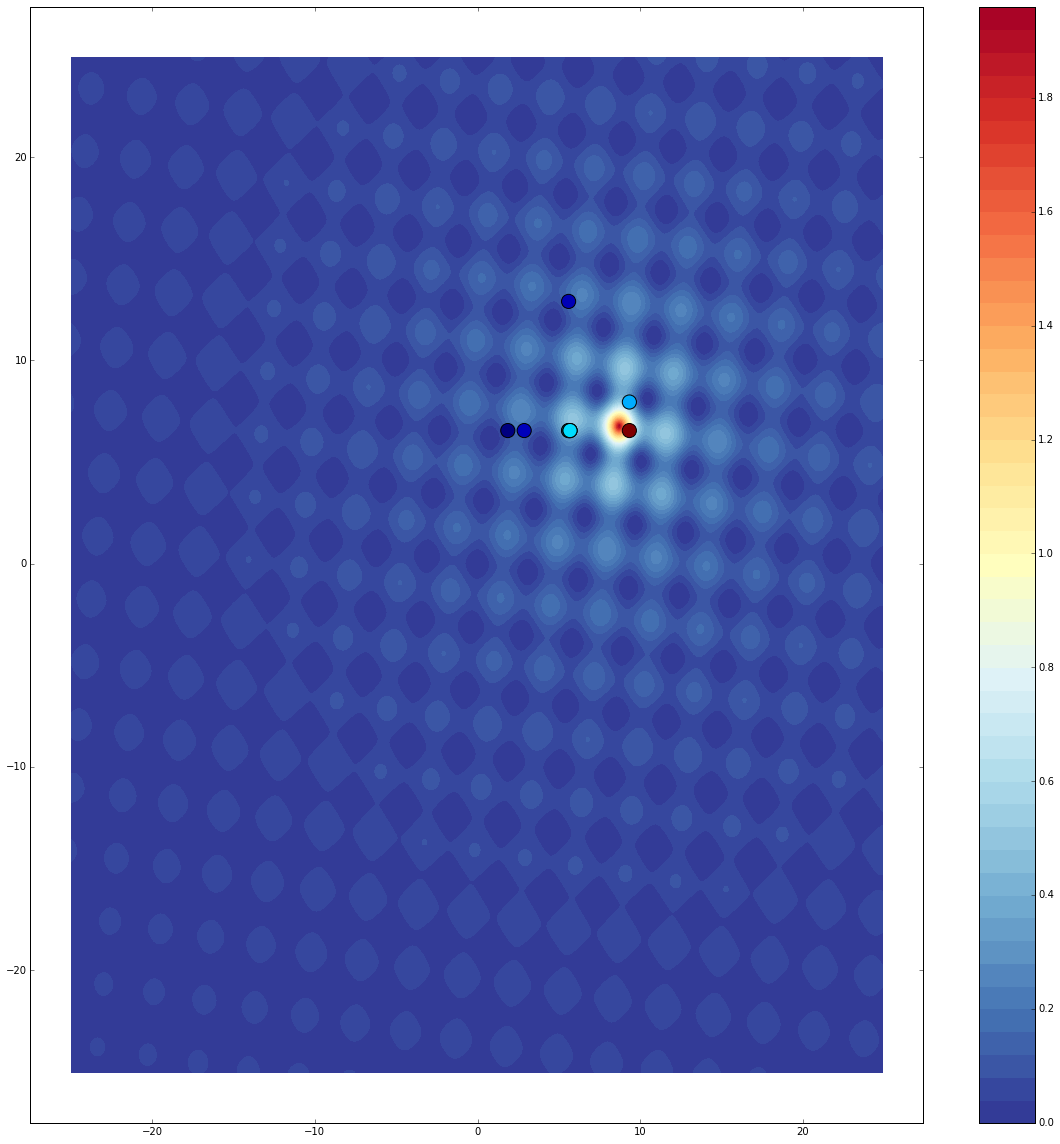

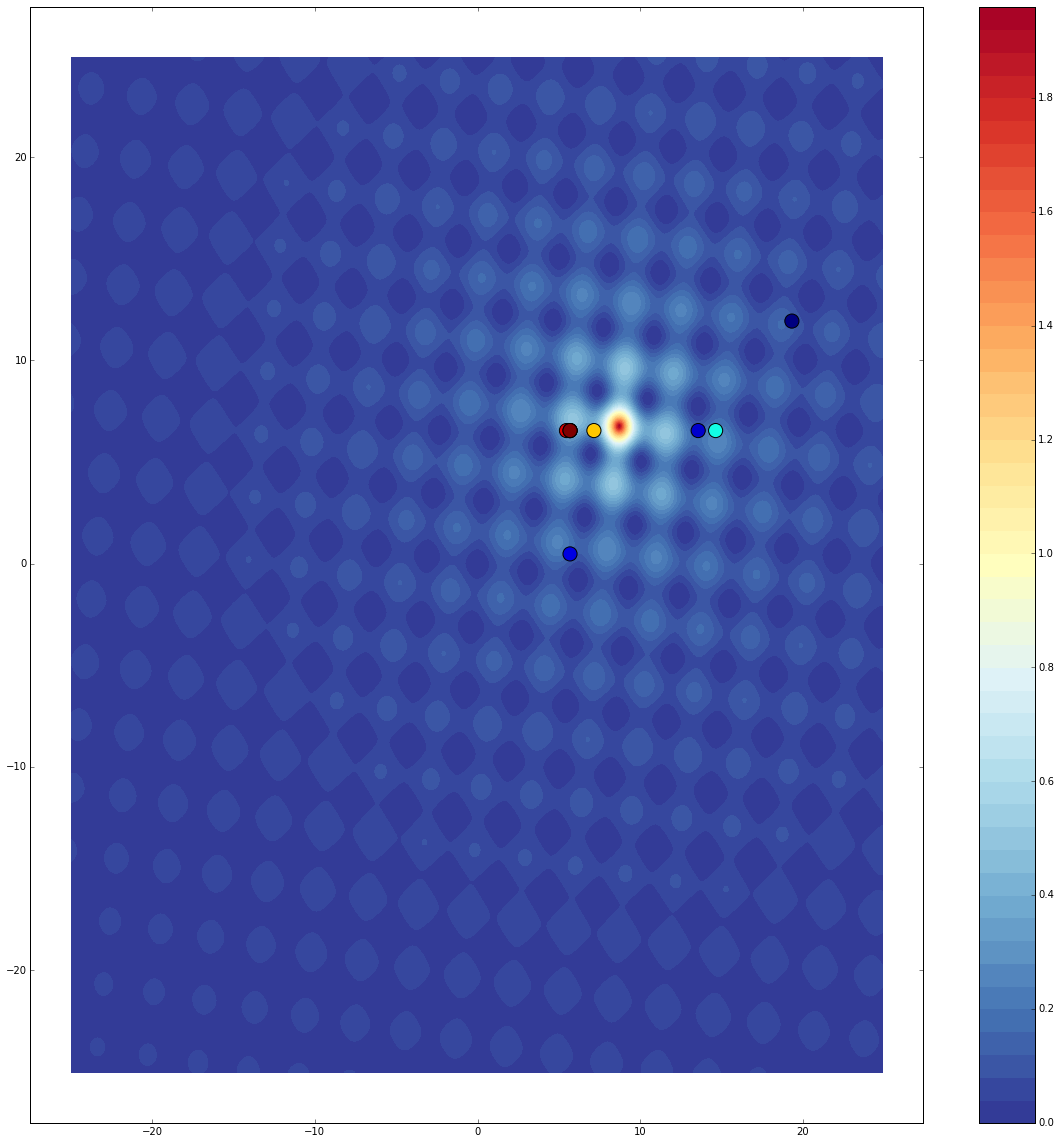

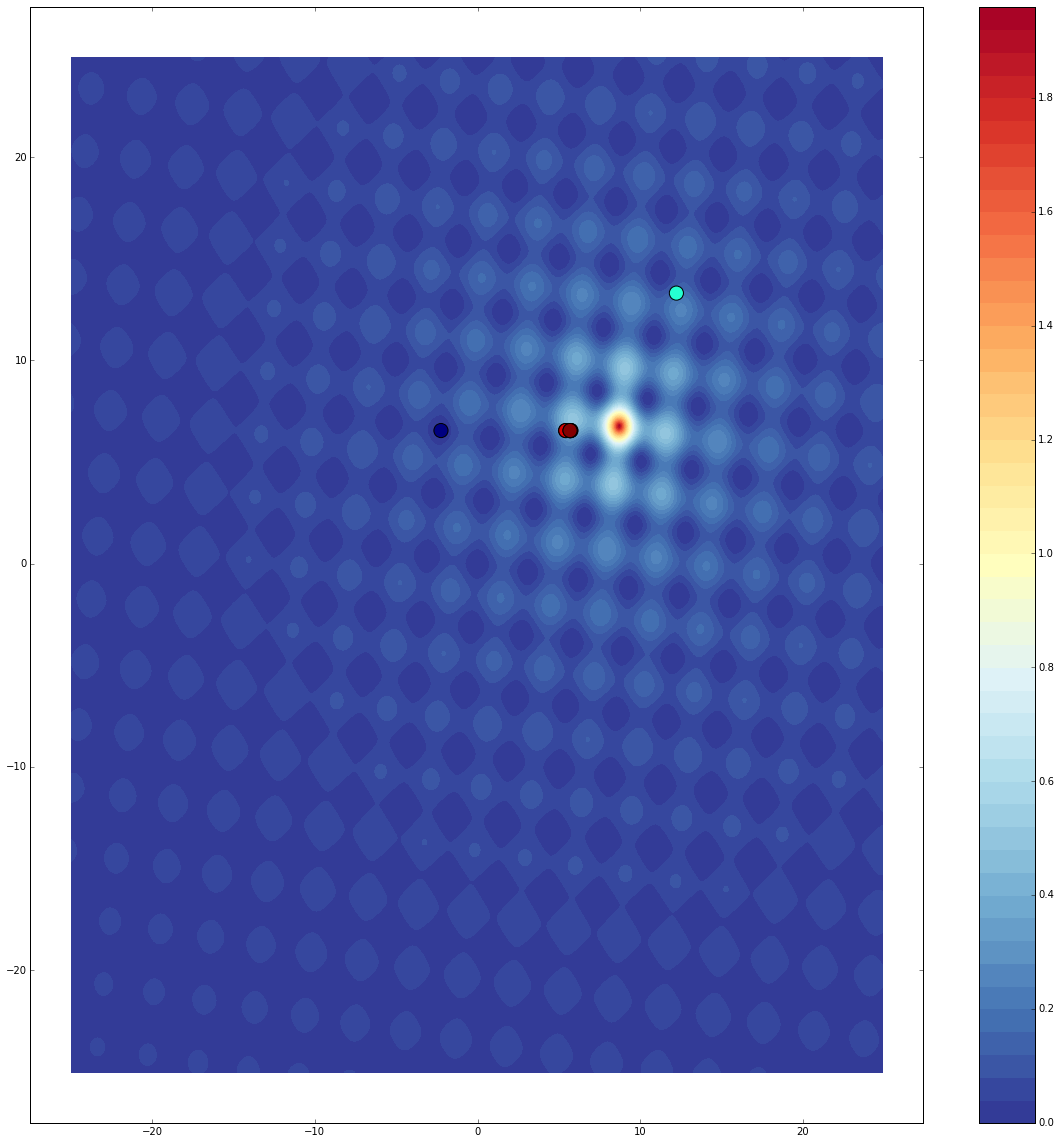

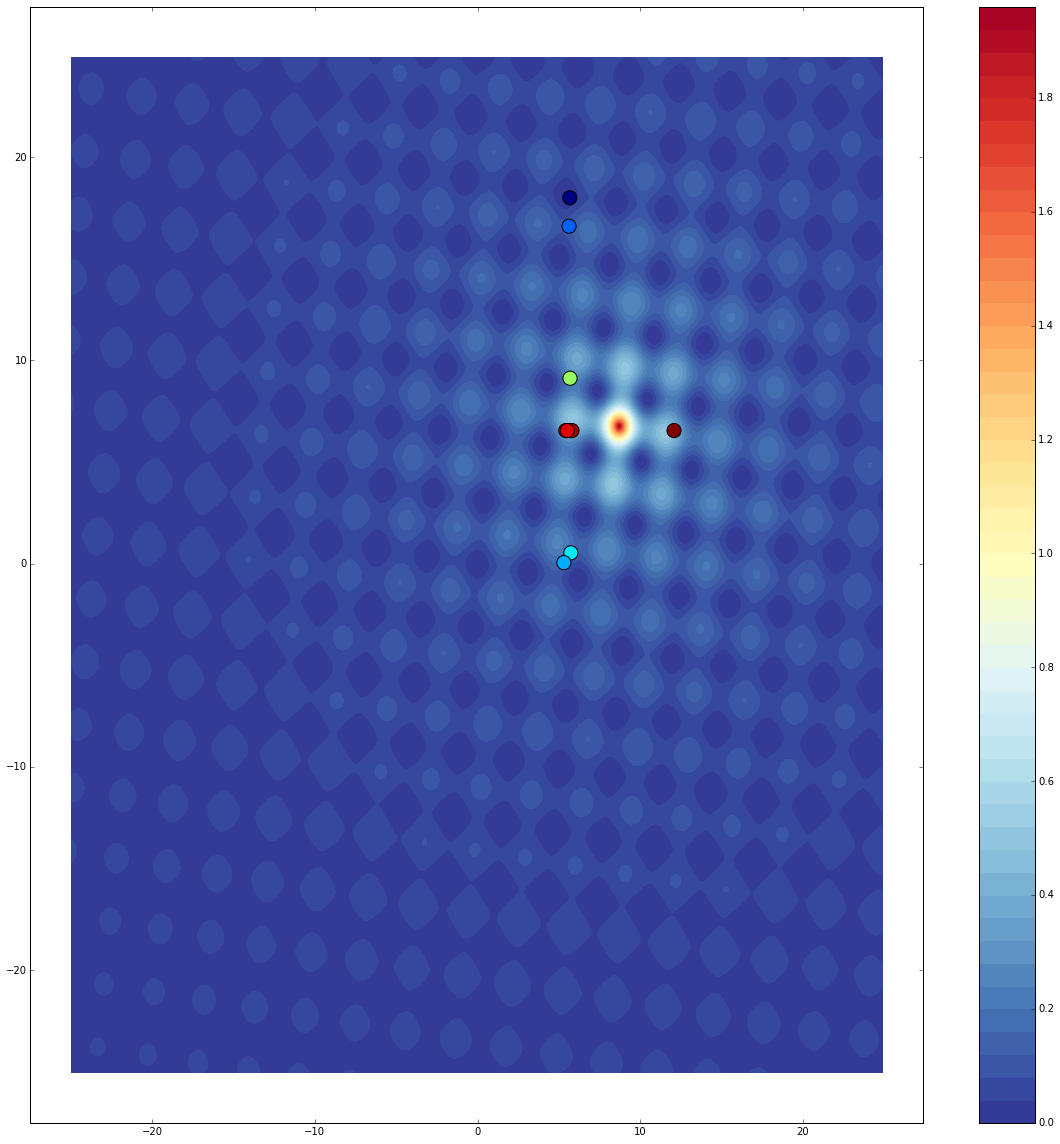

In [46]:
for g in range(NGEN):
    run_generation(population, plot=True)

In [47]:
for g in xrange(100):
    run_generation(population, plot=False)

In [60]:
from deap import algorithms

hof = tools.HallOfFame(1)


stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaSimple(toolbox.population(), toolbox,
                                   cxpb=0.5, mutpb=0.2, ngen=5000, 
                                   stats=stats, verbose=True, halloffame=hof)

gen	nevals	avg      	std      	min       	max     
0  	20    	0.0638751	0.0548661	0.00445594	0.256923
1  	10    	0.103886 	0.0639293	0.0248846 	0.256923
2  	9     	0.180149 	0.107547 	0.0333144 	0.453473
3  	19    	0.230656 	0.0987598	0.0403677 	0.447076
4  	19    	0.224642 	0.104816 	0.0213721 	0.449723
5  	11    	0.300574 	0.113383 	0.0193433 	0.449723
6  	3     	0.392126 	0.0599886	0.241942  	0.465366
7  	16    	0.427591 	0.0494639	0.306753  	0.518001
8  	18    	0.429836 	0.122698 	0.0340996 	0.602784
9  	9     	0.512509 	0.0739315	0.41148   	0.728722
10 	9     	0.542365 	0.16091  	0.0558336 	0.793378
11 	13    	0.632465 	0.12886  	0.376754  	0.873464
12 	14    	0.659924 	0.20434  	0.132319  	0.873464
13 	11    	0.743091 	0.191207 	0.0430428 	0.905043
14 	15    	0.744526 	0.209985 	0.120903  	0.882315
15 	11    	0.810633 	0.154039 	0.277712  	0.892404
16 	13    	0.848434 	0.11559  	0.351545  	0.901677
17 	14    	0.864048 	0.0981238	0.445288  	0.929478
18 	11    	0.906747 	0.0208606	

Remember - The global optimum is: $\mathbf{x} = (8.6998, 6.7665)$, $f(\mathbf{x}) = 2$

In [62]:
print hof[0]
print h1(hof[0])

[8.699806283603856, 6.766499589067555]
(1.9999874058382365,)


In [66]:
pop

[[8.699806732947565, 6.766499589067983],
 [8.699806732947565, 6.766499589067982],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.766499589067985],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.766499589067982],
 [8.699806732947565, 6.766499589067983],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.766499589067983],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.766499589067982],
 [8.699806732947565, 6.766499589067982],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.7664995890679815],
 [8.699806732947565, 6.053132660241044],
 [8.699806732947565, 6.766499589067983],
 [8.699806732947565, 6.766499589067983]]

In [61]:
record = stats.compile(pop)

logbook = tools.Logbook()
logbook.record(gen=0, evals=30, **record)
logbook.header = "min", "avg", "max"

print(logbook)

min     	avg    	max    
0.912731	1.94562	1.99999


# Equation modeling with genetic programming

In [67]:
import operator
from deap import gp

# Primitives are leaf nodes of a tree

pset = gp.PrimitiveSet("main", 2)

pset.renameArguments(ARG0="x")
pset.renameArguments(ARG1="y")


pset.addPrimitive(max, 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.mul, 2)
pset.addTerminal(3)

pset.addPrimitive(operator.neg, 1)



In [68]:
expr = gp.genFull(pset, min_=1, max_=3)
tree = gp.PrimitiveTree(expr)
print tree

add(max(mul(3, y), neg(y)), max(mul(3, x), neg(y)))


In [69]:
pset.addEphemeralConstant('rf', lambda: random.uniform(-1, 1))
pset.addEphemeralConstant('ri',   lambda: random.randint(-10, 10))

In [70]:
expr = gp.genFull(pset, min_=1, max_=3)
tree = gp.PrimitiveTree(expr)
print tree

mul(max(x, 1), mul(x, 3))


In [71]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin,
               pset=pset)

In [72]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)